In [71]:
import json
import numpy as np
from statistics import mean
import random
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


In [2]:
Results = {}

In [3]:
class ACO:
    #ACO Parameters
    alpha = 1
    beta = 5
    rho = 0.4
    rho1 = 0.5
    m = 10
    q0 = 0.9
    Nmax = 30
    w1 = 0.5
    w2 = 0.5
    minmax = False
    gupdate = False
    
    #Data
    Tasks = []
    task_len = 0
    VMs = []
    vm_len = 0
    
    #Matrix to Store the task-vm pheromone
    Pher = 0
    
    #Execution Times of the Tasks
    Et = 0
    
    #Transmission times of the tasks
    Tt = 0
    
    # Total runtime  = Transmission + Execution Times
    TRT = 0
    
    # VM Computation 
    Vm_comp = 0
    vm_comp_avg = 0
    
    #Sum of all the execution times
    total_exec_time = 0
    #Sum of all input file sizes
    total_file_size = 0
    # Max Computation power VM , Min Computation Power VM
    max_comp = 0
    min_comp = 0
    # Bandwidth of the one with max and min comp power
    max_comp_bw = 0
    min_comp_bw = 0
    # C_Time_min and C_Time_max
    c_time_min = 0
    c_time_max = 0
    # Max cost VM cost, min cost vm cost
    min_ucost = 0
    max_ucost = 0
    # TotalCostmin and max
    total_cost_min = 0
    total_cost_max = 0
    
    # Related to the Current Iteration
    M = 0 #Mapping from tasks to VMs: [n_ants, n_tasks, n_vms]
    vm_completetime = 0 # [n_ants, n_vms] Sum of execution times for all tasks assigned to it
    c_time_i = 0 # Completion times for the set of tasks [n_ants]
    total_cost_i = 0 # Cost of using VMs [n_ants]  
    time_cf = 0 # Time Constraint Function: [n_ants]
    c_cost_i = 0 # Cost Constraint Function: [n_ants]
    L = 0 # w1*time_cf + w2*c_cost_i: [n_ants]
    
    
    L_global_opt = -1
    M_global_opt = -1 # [n_tasks, n_vms]
    current_total_exectime = 0 # [n_ants] total execution time till now over all VMs
    
    
    # Performance Variables of Global Optimum after each iteration
    BL = 0 # Balanced Load Evaluation Function [n_iters]
    Costs = 0 # Total Cost [n_iters]
    Makespans = 0 # Total Makespans [n_iters]
    
    
    #Mostly wont need these as variables:
    # Completion time of a VM (Sum of runtimes of all tasks assigned to it)
    # VM_completetime = []
    # Total Completion time
    # Max_VM_completetime
    # Cost of completing all tasks
    # Sum over all VM ( Unit cost of VM * Max time to complete )
    # Cost Constraint Function, Time constraint function, overall objective function
    
    def __init__(self, alpha = 1, beta = 5,rho = 0.4,rho1 = 0.5,m = 10,q0 = 0.9,Nmax = 30,w1 = 0.5, minmax = False, gupdate = False):
        self.alpha = alpha
        self.beta = beta
        self.rho = float(rho)
        self.rho1 = float(rho1)
        self.m = m
        self.q0 = q0
        self.Nmax = Nmax
        self.w1 = float(w1) # For Time
        self.w2 = 1.0 - float(w1) # For Cost
        self.minmax = minmax
        
    
    #Laod the data
    def loadData(self, vm_file, task_file):
        fvm = open(vm_file, "r")
        ftask = open(task_file, "r")
        vm_data = (fvm.read())
        task_data = (ftask.read())
        self.VMs = json.loads(vm_data)
        self.Tasks = json.loads(task_data)
        
        self.calcValues()
        
        
    def calcValues(self):
        self.task_len = len(self.Tasks)
        self.vm_len = len(self.VMs)
        
        self.setVmCompCost()
        
        self.setTotalTimes()
        self.setCTimes()
        
        self.setInitialPheromone()
    
    
    def setTotalTimes(self):
        self.setExecutionTimes()
        self.setTransmissionTimes()
        
        self.TRT = self.Et + self.Tt
    
    def setVmCompCost(self):
        self.Vm_comp = np.zeros((self.vm_len))
        self.Vm_comp[0] = self.VMs[0]['mips'] * self.VMs[0]['n_pe']
        
        self.max_comp = self.Vm_comp[0]
        self.max_comp_bw = self.VMs[0]["bw"]
        self.min_comp = self.Vm_comp[0]
        self.min_comp_bw = self.VMs[0]["bw"]
        
        self.max_ucost = self.VMs[0]['cost']
        self.min_ucost = self.VMs[0]['cost']
        self.vm_comp_avg = self.Vm_comp[0]
        
        for i in range(1, self.vm_len):
            self.Vm_comp[i] = self.VMs[i]['mips'] * self.VMs[i]['n_pe']
            self.vm_comp_avg += self.Vm_comp[i]
            if (self.Vm_comp[i] > self.max_comp):
                self.max_comp = self.Vm_comp[i]
                self.max_comp_bw = self.VMs[i]['bw']
            if (self.Vm_comp[i] < self.min_comp):
                self.min_comp = self.Vm_comp[i]
                self.min_comp_bw = self.VMs[i]['bw']
                
            if (self.VMs[i]['cost'] < self.min_ucost):
                self.min_ucost  = self.VMs[i]['cost']
            if (self.VMs[i]['cost'] > self.max_ucost):
                self.max_ucost  = self.VMs[i]['cost']
                
        self.vm_comp_avg = self.vm_comp_avg / float(self.vm_len)
        
    def setExecutionTimes(self):
        #Uses length of the task and processing power of the VM
        # L/P
        # P = mips*n_pe
        
        self.Et = np.zeros((self.task_len, self.vm_len))
        for i in range(self.task_len):
            for j in range(self.vm_len):
                p = self.Vm_comp[j]
                self.Et[i][j] = self.Tasks[i]["length"] / float(p)
            self.total_exec_time += self.Tasks[i]["length"]
    
    def setTransmissionTimes(self):
        # Uses file size of task and bandwidth of vm
        # fs/bw
        self.Tt = np.zeros((self.task_len, self.vm_len))
        for i in range(self.task_len):
            for j in range(self.vm_len):
                self.Tt[i][j] = self.Tasks[i]["file"] / float(self.VMs[j]["bw"])
            self.total_file_size += self.Tasks[i]["file"]
            
    def setCTimes(self):
        self.c_time_min = ((self.total_exec_time) / (self.vm_len * self.max_comp)) + (self.total_file_size/ (self.vm_len * self.max_comp_bw)) 
        self.c_time_max = ((self.total_exec_time) / (self.vm_len * self.min_comp)) + (self.total_file_size/ (self.vm_len * self.min_comp_bw))
    
        self.total_cost_min = self.c_time_min * self.min_ucost
        self.total_cost_max = self.c_time_max * self.max_ucost
        
    def setInitialPheromone(self):
        # vm comp / average comp
        self.Pher = np.zeros((self.task_len,self.vm_len))
        for j in range(self.vm_len):
            t0 = self.Vm_comp[j] / float(self.vm_comp_avg)
            for i in range(self.task_len):
                self.Pher[i][j] = t0
                
                
    def findGlobalOptMetrics(self):
        LBavg = 0.0
        LB = np.zeros((self.vm_len))
        costs = np.zeros((self.vm_len))
        
        GlobalCost = 0.0
        GlobalMakespan = 0.0
        
        for i in range(self.task_len):
            for j in range(self.vm_len):
                if (self.M_global_opt[i][j] == 1):
                    LBavg += self.TRT[i][j]
                    LB[j] += self.TRT[i][j]
                    costs[j] += self.TRT[i][j]*self.VMs[j]["cost"]
                    
        GlobalCost = max(costs)
        GlobalMakespan = max(LB)
        LBavg /= float(self.vm_len)
        
        BalLoad = 0.0
        for i in range(self.vm_len):
            BalLoad += pow((LB[i] - LBavg),2)
        BalLoad /= self.vm_len
        BalLoad = math.sqrt(BalLoad)
        
        return BalLoad, GlobalCost, GlobalMakespan
    
    def chooseVM(self, tid, a):
        if (tid == 0):
            ret = random.randint(0, self.vm_len-1)
            assert(ret >=0 and ret<self.vm_len)
        
        q = random.random()
        selectedvm = 0
        load = np.zeros((self.vm_len))
        heuristic = np.zeros((self.vm_len))
        total_heuristic = 0.0
        
        avg_e = self.current_total_exectime[a] / float(self.vm_len)
        for l in range(self.vm_len):
            load[l] = 1.0 - ((self.vm_completetime[a][l] - avg_e)/self.current_total_exectime[a])
            heuristic[l] = pow(self.Pher[tid][l], self.alpha) * pow(load[l]/self.Et[tid][l], self.beta)
            total_heuristic += heuristic[l]
            
        if (q < self.q0):
            selectedvm = 0
            maxv = heuristic[0]
            for v in range(self.vm_len):
                if (heuristic[v] > maxv):
                    selectedvm = v
                    maxv = heuristic[v]
            assert(selectedvm >=0 and selectedvm <self.vm_len)
            return selectedvm
        else:
            limits = np.zeros(self.vm_len)
            cumul = 0.0
            for i in range(self.vm_len):
                limits[i] = 1000*(heuristic[i]/total_heuristic) + cumul
                cumul += limits[i]
                
            limits[self.vm_len - 1] = 1000
            s = random.randint(0, 1000)
            ret = 0
            for i in range(self.vm_len):
                if (s > limits[i]):
                    ret = i+1
            assert(ret >=0 and ret<self.vm_len)
            return ret
    
    def preIterSetup(self):
        self.M = np.zeros((self.m, self.task_len, self.vm_len)) #Mapping from tasks to VMs: [n_ants, n_tasks, n_vms]
        self.vm_completetime = np.zeros((self.m, self.vm_len)) # [n_ants, n_vms] Sum of execution times for all tasks assigned to it
        self.c_time_i =np.zeros((self.m)) # Completion times for the set of tasks [n_ants]
        self.total_cost_i = np.zeros((self.m)) # Cost of using VMs [n_ants]  
        self.time_cf = np.zeros((self.m)) # Time Constraint Function: [n_ants]
        self.c_cost_i = np.zeros((self.m)) # Cost Constraint Function: [n_ants]
        self.L = np.zeros((self.m)) # w1*time_cf + w2*c_cost_i: [n_ants]
        
        self.current_total_exectime = np.zeros((self.m)) # Current total of all VM executon times
    
    def updatePheromone(self, a):
        for i in range(self.task_len):
            for j in range(self.vm_len):
                increment = 0.0
                if (self.M[a][i][j] == 1):
                    increment = 1.0 / float(self.L[a])
                self.Pher[i][j] = (1 - self.rho)*self.Pher[i][j] + self.rho*increment
    
    def updateGlobalPheromone(self):
        for i in range(self.task_len):
            for j in range(self.vm_len):
                increment = 0.0
                if (self.M_global_opt[i][j] == 1):
                    increment = 1.0 / float(self.L_global_opt)
                self.Pher[i][j] = (1 - self.rho1)*self.Pher[i][j] + self.rho1*increment
    
    def updateBestPheromone(self):
        ind = 0
        best = self.L[0]
        for a in range(self.m):
            if (self.L[a] < best):
                best = self.L[a]
                ind = a
        
        for i in range(self.task_len):
            for j in range(self.vm_len):
                increment = 0.0
                if (self.M[ind][i][j] == 1):
                    increment = 1.0 / float(best)
                self.Pher[i][j] = (1 - self.rho1)*self.Pher[i][j] + self.rho1*increment
    
    def oneIteration(self, it):
        self.preIterSetup()
        for a in range(self.m): 
            for t in range(self.task_len):
                chosen_vm = self.chooseVM(t,a)
                assert(chosen_vm >= 0 and chosen_vm < self.vm_len)
                self.M[a][t][chosen_vm]  = 1
                self.vm_completetime[a][chosen_vm] +=  self.TRT[t][chosen_vm]
                self.current_total_exectime[a] += self.TRT[t][chosen_vm]
                if (self.vm_completetime[a][chosen_vm] > self.c_time_i[a]):
                    self.c_time_i[a] = self.vm_completetime[a][chosen_vm]
                self.total_cost_i[a] += self.TRT[t][chosen_vm] * self.VMs[chosen_vm]["cost"]
                
            self.time_cf[a] = (self.c_time_i[a] - self.c_time_min) / (self.c_time_max - self.c_time_min)
            self.c_cost_i[a] = ( self.total_cost_i[a] - self.total_cost_min ) / ( self.total_cost_max - self.total_cost_min)
            self.L[a] =  ((self.w1 * self.time_cf[a]) + (self.w2 * self.c_cost_i[a]))
            # Setting Data after all assignments of Tasks to VMs
        
        #print ("Local Optimum is: ", min(self.L))
        for a in range(self.m):
            if (self.minmax == False):
                self.updatePheromone(a)
            if (self.L_global_opt == -1):
                self.L_global_opt = self.L[a]
                self.M_global_opt = self.M[a]
            elif (self.L[a] < self.L_global_opt):
                #print ("New Optimum: ", self.L_global_opt, self.L[a])
                self.L_global_opt = self.L[a]
                self.M_global_opt = self.M[a]
        
        if (self.minmax == True):
            self.updateBestPheromone()
        if (self.gupdate == True):
            self.updateGlobalPheromone()
        self.BL[it], self.Costs[it], self.Makespans[it] = self.findGlobalOptMetrics()
        
    def run(self):
        self.setInitialPheromone()
        self.BL = np.zeros((self.Nmax))
        self.Costs = np.zeros((self.Nmax))
        self.Makespans = np.zeros((self.Nmax))
        
        for it in range(self.Nmax):
            self.oneIteration(it)
        
        
    def saveResults(self, filename):
        f = open(filename, "w")
        res  = {}
        res["BL"] = self.BL[self.Nmax-1].tolist();
        res["cost"] = self.Costs[self.Nmax-1].tolist()
        res["makespan"] = self.Makespans[self.Nmax-1].tolist()
        res["M"] = self.M_global_opt.tolist()
    
        res_s = json.dumps(res)
        f.write(res_s)
        return res
        


In [4]:
ns = [100, 150, 200, 300, 1000]
letters = ['a', 'b', 'c', 'd']

In [6]:
for l in letters:
    for n in ns: 
        if (l == 'a'):
            aco = ACO()
        elif (l == 'b'):
            aco = ACO(gupdate = True)
        elif (l == 'c'):
            aco = ACO(minmax = True)
        elif (l == 'd'):
            aco = ACO(gupdate = True, minmax = True)
            
        aco.loadData("vm_data.txt", "Task_Data/task_data_gocj_" + str(n) + ".txt")
        aco.run()
        fn = str(n) + "_" + l + ".txt"
        Results[fn] = aco.saveResults("Results/" + fn)

C:\Users\Asavari\Anaconda3\lib\site-packages\ipykernel_launcher.py:237: RuntimeWarning: invalid value encountered in double_scalars


In [7]:
print (Results.keys())

dict_keys(['100_a.txt', '150_a.txt', '200_a.txt', '300_a.txt', '1000_a.txt', '100_b.txt', '150_b.txt', '200_b.txt', '300_b.txt', '1000_b.txt', '100_c.txt', '150_c.txt', '200_c.txt', '300_c.txt', '1000_c.txt', '100_d.txt', '150_d.txt', '200_d.txt', '300_d.txt', '1000_d.txt'])


In [42]:
BLs = []
Costs = []
Makespans = []

In [43]:
for k in Results.keys():
    n = int(k.split('_')[0])
    l = k.split('_')[1].split('.')[0]
    BLs.append([n, l, Results[k]["BL"]])
    Costs.append([n, l, Results[k]["cost"]])
    Makespans.append([n, l, Results[k]["makespan"]])


In [44]:
BLs = np.array(BLs)
Costs = np.array(Costs)
Makespans = np.array(Makespans)

In [73]:
BLs_temp = BLs[:,1]
colors = ['red', 'green', 'yellow', 'pink']
classes = ['All', 'Global + All', 'Current Best', 'Current Best + Global']

In [74]:
BLs_temp[BLs_temp == 'a'] = 'red'
BLs_temp[BLs_temp == 'b'] = 'green'
BLs_temp[BLs_temp == 'c'] = 'yellow'
BLs_temp[BLs_temp == 'd'] = 'pink'

In [78]:
recs =[]
for i in range(0,len(colors)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=colors[i]))

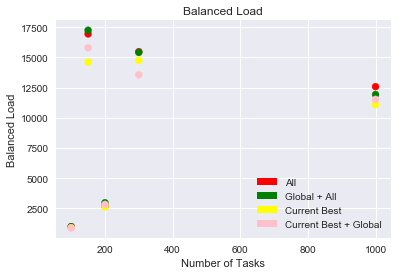

In [79]:
plt.scatter(BLs[:,0], BLs[:,2], c=BLs_temp)
plt.legend(recs,classes,loc=4)
plt.title('Balanced Load')
plt.xlabel('Number of Tasks')
plt.ylabel('Balanced Load')
plt.show()

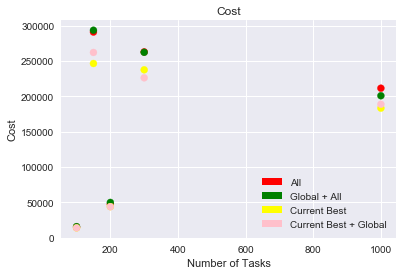

In [77]:
plt.scatter(Costs[:,0], Costs[:,2], c=BLs_temp)
plt.legend(recs,classes,loc=4)
plt.title('Cost')
plt.xlabel('Number of Tasks')
plt.ylabel('Cost')
plt.show()

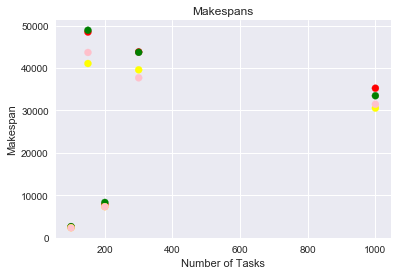

In [80]:
plt.scatter(Makespans[:,0], Makespans[:,2], c=BLs_temp)
plt.title('Makespans')
plt.xlabel('Number of Tasks')
plt.ylabel('Makespan')
plt.show()